In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nixtla import NixtlaClient
from dotenv import load_dotenv
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error, max_error, explained_variance_score
import numpy as np
from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro, levene, f_oneway, kruskal
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from prophet import Prophet
from lightgbm import LGBMRegressor
load_dotenv()

True

# METHOD

## Data Analitics:

- Data curation
- Data description
- Data Inference


Dado que los datos de count_in son incrementales y no tenemos datos exactos de las personas que entra y salen del parque, usamos el número de personas que entran por día y haremos la predicción por días en lugar de por horas.
A continuación nos quedamos con las filas con valor máximo de count_in por cada día.

In [2]:
ocupacion = pd.read_csv("data/datos_ocupacion.csv")
ocupacion['timestamp'] = pd.to_datetime(ocupacion['timestamp'], dayfirst=True)
ocupacion['fecha'] = ocupacion['timestamp'].dt.date
df_ocupacion_dia = ocupacion.loc[ocupacion.groupby('fecha')['count_in'].idxmax()]
df_ocupacion_dia = df_ocupacion_dia[['fecha', 'count_in']]
df_ocupacion_dia

,fecha,count_in
11060,2024-09-10,98.0
12870,2024-09-11,114.0
14261,2024-09-12,133.0
15819,2024-09-13,167.0
17349,2024-09-14,199.0
...,...,...
7106,2024-12-06,151.0
8339,2024-12-07,128.0
9539,2024-12-08,163.0
10819,2024-12-09,50.0


Siguiendo la lógica anterior y para poder hacer el análisis y estudiar la correlación entre las personas en el parque y las distintas variables debemos agregarlas por días, teniendo asíu granularidad diaria en todas ellas

-  **temperatura**:  _temp_min_, _temp_max_ y _temp_promedio_
-  **velocidadviento**:  _viento_promedio_ y _viento_max_ 
- **lluvia**: _precipitacion_acumulada_ y _duracion_lluvia_min_
- **intensidadlluvia**: _intensidad_max_ e _intensidad_promedio_

TEMPERATURA PROMEDIO : 3 intervalos: fria ( < 15 ) moderada (15 - 27) y alta (>27) 

In [3]:
meteo = pd.read_csv("data/datos_meteo.csv")
meteo['timestamp'] = pd.to_datetime(meteo['timestamp'], dayfirst=True)


meteo['fecha'] = meteo['timestamp'].dt.date

meteo = meteo.groupby('fecha').agg(
    temp_min=('temperatura', 'min'),
    temp_max=('temperatura', 'max'),
    temp_promedio=('temperatura', 'mean'),

    viento_max=('velocidadviento', 'max'),
    viento_promedio=('velocidadviento', 'mean'),

    precioutacion_acumulada=('lluvia', 'sum'),
    duracion_lluvia_min=('lluvia', lambda x: (x > 0).sum() * 5), 
    intensidad_max=('intensidadlluvia', 'max'),
    intensidad_promedio=('intensidadlluvia', 'mean')
).reset_index()

meteo = meteo.round(2)
meteo

,fecha,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,precioutacion_acumulada,duracion_lluvia_min,intensidad_max,intensidad_promedio
0,2024-09-10,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0
1,2024-09-11,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0
2,2024-09-12,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0
3,2024-09-13,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0
4,2024-09-14,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
88,2024-12-07,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0
89,2024-12-08,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0
90,2024-12-09,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0
91,2024-12-10,6.8,16.6,10.76,10,3.21,0.0,0,0.0,0.0


Juntamos los datos de ocupación y las variables climáticas en un mismo dataframe final

In [4]:
df = pd.merge(df_ocupacion_dia, meteo, on='fecha', how='left')

In [5]:
df

,fecha,count_in,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,precioutacion_acumulada,duracion_lluvia_min,intensidad_max,intensidad_promedio
0,2024-09-10,98.0,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0
1,2024-09-11,114.0,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0
2,2024-09-12,133.0,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0
3,2024-09-13,167.0,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0
4,2024-09-14,199.0,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
87,2024-12-06,151.0,12.9,25.9,19.13,18,5.29,0.0,0,0.0,0.0
88,2024-12-07,128.0,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0
89,2024-12-08,163.0,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0
90,2024-12-09,50.0,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0


Vamos a estudiar el rango de la variable respuesta

In [6]:
print(df['count_in'].describe())

count     92.00000
mean     132.73913
std       40.89248
min       50.00000
25%      107.50000
50%      124.50000
75%      153.25000
max      254.00000
Name: count_in, dtype: float64


Vamos a estudiar la correlación entre las distintas variables y el número de personas en el parque ese día (variable respuesta).  
Utilizaremos la Correlación de Pearson y representaremos los resultados en heatmap:  
- Valores cercanos a +1: correlación positiva fuerte
- Valores cercanos a -1: correlación negativa fuerte
- Valores cercanos a 0: sin correlación

Correlaciones con count_in:
count_in                   1.000000
temp_min                   0.256609
temp_promedio              0.248542
temp_max                   0.158723
viento_promedio            0.054132
viento_max                 0.045748
intensidad_max            -0.104990
intensidad_promedio       -0.151955
precioutacion_acumulada   -0.173954
duracion_lluvia_min       -0.225924
Name: count_in, dtype: float64


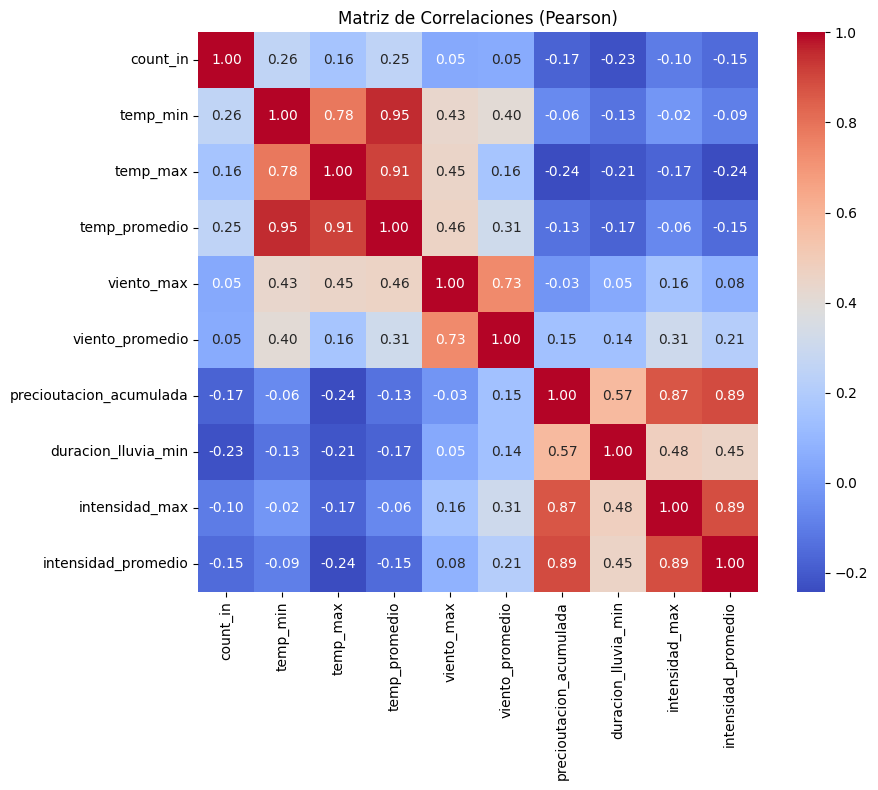

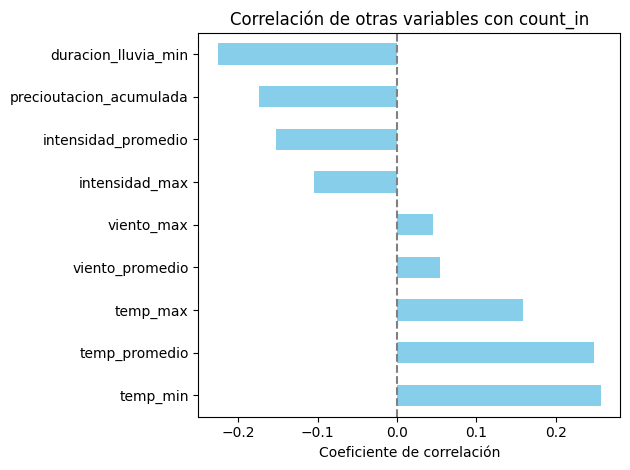

In [7]:
df_corr= df.select_dtypes(include='number')
correlaciones = df_corr.corr(method='pearson')

correlacion_con_count_in = correlaciones['count_in'].sort_values(ascending=False)

print("Correlaciones con count_in:")
print(correlacion_con_count_in)

plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlaciones (Pearson)')
plt.tight_layout()
plt.show()

correlacion_con_count_in.drop('count_in').plot(kind='barh', color='skyblue')
plt.title('Correlación de otras variables con count_in')
plt.xlabel('Coeficiente de correlación')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


## Data Visualization

- time series using timeGPT / Prohet / ...
LOOK FOR THE BEST TECHNIQUE FOR OUR DATA

Hacer solo con count_in y con día de la semana etc

In [8]:
df_ts = df[['fecha', 'count_in']].copy()
df_ts.rename(columns={'fecha': 'ds', 'count_in': 'y'}, inplace=True)
df_ts['ds'] = pd.to_datetime(df_ts['ds'])
df_ts

,ds,y
0,2024-09-10,98.0
1,2024-09-11,114.0
2,2024-09-12,133.0
3,2024-09-13,167.0
4,2024-09-14,199.0
...,...,...
87,2024-12-06,151.0
88,2024-12-07,128.0
89,2024-12-08,163.0
90,2024-12-09,50.0


In [9]:
API_KEY = os.getenv("TIMEGPT_API_KEY")
print(API_KEY)
nixtla_client = NixtlaClient(API_KEY)
forecast = nixtla_client.forecast(df=df_ts, h=14)
print(forecast)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


nixak-rmZYlpmv3ZOHG73YFyLJr47V6EGbm1ksQygYvo1X3SgGkfVbDMCoYFW58gpAZcAFeORRML7FFyz9XJ10


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 3 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 4 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 5 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, e

ApiError: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}

NameError: name 'forecast' is not defined

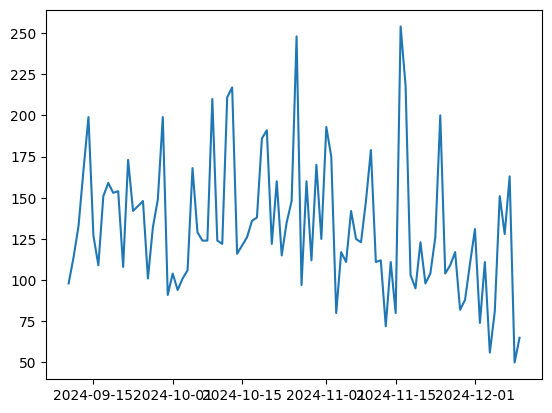

In [ ]:
plt.plot(df_ts['ds'], df_ts['y'], label='Histórico')
plt.plot(forecast['ds'], forecast['TimeGPT'], label='Forecast', linestyle='--')
plt.legend()
plt.title('Predicción de visitantes al parque')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_train = df_ts.iloc[:-14]  
df_test = df_ts.iloc[-14:]

forecast = nixtla_client.forecast(df=df_train, h=14)
forecast = forecast.copy()
forecast['y_true'] = df_test['y'].values 
mae = mean_absolute_error(forecast['y_true'], forecast['TimeGPT'])
rmse = np.sqrt(mean_squared_error(forecast['y_true'], forecast['TimeGPT']))
r2 = r2_score(forecast['y_true'], forecast['TimeGPT'])
mape = mean_absolute_percentage_error(forecast['y_true'], forecast['TimeGPT'])

print("MAE TimeGPT:", round(mae, 2))
print("RMSE TimeGPT:", round(rmse, 2))
print("R² TimeGPT:", round(r2, 4))
print("MAPE TimeGPT:", round(mape * 100, 2), "%")



INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


📊 MAE TimeGPT: 36.56
📉 RMSE TimeGPT: 42.5
📈 R² TimeGPT: -0.5818
📌 MAPE TimeGPT: 49.22 %


- ver si es serie temporal
- ver que modelo utilizar
- como parametizar ese modelo ( cuanto datos historicos coges apra predecir )

## Variables dummys y categóricas y test de hipótesis

In [10]:
df_dummy = df.copy()
df_dummy['fecha'] = pd.to_datetime(df_dummy['fecha'])
df_dummy['lluvia'] = (df_dummy['precioutacion_acumulada'] > 0).astype(int)
df_dummy['fin_de_semana'] = df_dummy['fecha'].dt.dayofweek.isin([5, 6]).astype(int)
bins = [-float('inf'), 15, 26, float('inf')]
labels = ['fría', 'moderada', 'alta']
df_dummy['categoria_temperatura'] = pd.cut(df_dummy['temp_promedio'], bins=bins, labels=labels)
df_dummy

,fecha,count_in,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,precioutacion_acumulada,duracion_lluvia_min,intensidad_max,intensidad_promedio,lluvia,fin_de_semana,categoria_temperatura
0,2024-09-10,98.0,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0,0,0,moderada
1,2024-09-11,114.0,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0,0,0,moderada
2,2024-09-12,133.0,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0,0,0,moderada
3,2024-09-13,167.0,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0,0,0,moderada
4,2024-09-14,199.0,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0,1,1,moderada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2024-12-06,151.0,12.9,25.9,19.13,18,5.29,0.0,0,0.0,0.0,0,0,moderada
88,2024-12-07,128.0,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0,0,1,moderada
89,2024-12-08,163.0,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0,0,1,fría
90,2024-12-09,50.0,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0,0,0,fría


## Hacemos un test de hipótisis para estudiar si la lluvia afecta o no al número de visitantes

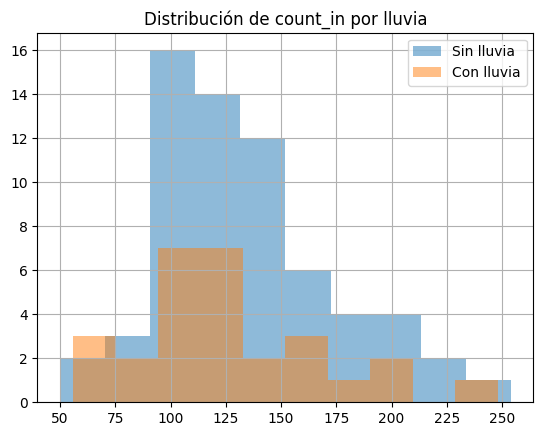

p-valor Shapiro (sin lluvia): 0.0678124725818634
p-valor Shapiro (con lluvia): 0.11722476035356522


In [11]:
df_dummy[df_dummy['lluvia'] == 0]['count_in'].hist(alpha=0.5, label='Sin lluvia')
df_dummy[df_dummy['lluvia'] == 1]['count_in'].hist(alpha=0.5, label='Con lluvia')
plt.legend()
plt.title('Distribución de count_in por lluvia')
plt.show()

shapiro_sin = shapiro(df_dummy[df_dummy['lluvia'] == 0]['count_in'])
shapiro_con = shapiro(df_dummy[df_dummy['lluvia'] == 1]['count_in'])

print("p-valor Shapiro (sin lluvia):", shapiro_sin.pvalue)
print("p-valor Shapiro (con lluvia):", shapiro_con.pvalue)


Normalidad en los datos, usamos test t

Hipótesis nula (H₀): La media de visitantes es la misma en días con y sin lluvia.  
Hipótesis alternativa (H₁): La media de visitantes es diferente entre días con y sin lluvia

In [12]:
hipo_lluvia = df_dummy[['count_in', 'lluvia']]

sin_lluvia = hipo_lluvia[hipo_lluvia['lluvia'] == 0]['count_in']
con_lluvia = hipo_lluvia[hipo_lluvia['lluvia'] == 1]['count_in']

t_stat, p_val_ttest = ttest_ind(sin_lluvia, con_lluvia, equal_var=False)


print("Test t: p-value =", p_val_ttest)


Test t: p-value = 0.3647634304049451


Resultado p-valor mayor que 0.05, lo que significa que no se rechaza la hipótesis nula.
> **Conclusión:** No hay evidencia estadísticamente significativa para afirmar que la lluvia afecte el número de visitantes al parque.


## Hacemos un test de hipótisis para estudiar si que sea fin de semana o no afecta al número de visitantes

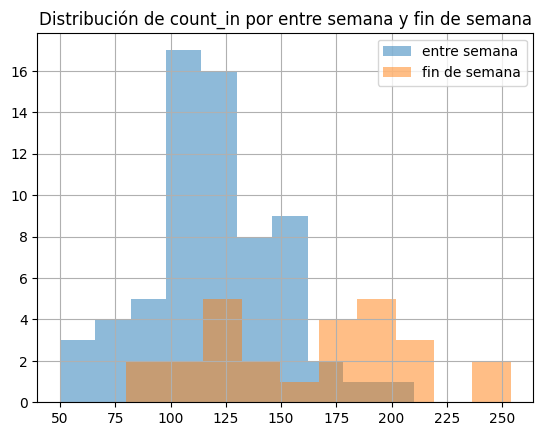

p-valor Shapiro (entre semana): 0.6183127760887146
p-valor Shapiro (fin de semana): 0.8032315373420715


In [13]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt

df_dummy[df_dummy['fin_de_semana'] == 0]['count_in'].hist(alpha=0.5, label='entre semana')
df_dummy[df_dummy['fin_de_semana'] == 1]['count_in'].hist(alpha=0.5, label='fin de semana')
plt.legend()
plt.title('Distribución de count_in por entre semana y fin de semana')
plt.show()

shapiro_entre = shapiro(df_dummy[df_dummy['fin_de_semana'] == 0]['count_in'])
shapiro_fin = shapiro(df_dummy[df_dummy['fin_de_semana'] == 1]['count_in'])

print("p-valor Shapiro (entre semana):", shapiro_entre.pvalue)
print("p-valor Shapiro (fin de semana):", shapiro_fin.pvalue)


p-valores son mayores que 0.05, no se rechaza la normalidad, así que usamos el t-test.

H₀ (nula): El número de visitantes es igual en fines de semana y días de semana.

H₁ (alternativa): El número de visitantes es diferente entre fines de semana y días de semana.

In [14]:
from scipy.stats import ttest_ind

entre_semana = df_dummy[df_dummy['fin_de_semana'] == 0]['count_in']
fin_de_semana = df_dummy[df_dummy['fin_de_semana'] == 1]['count_in']

t_stat, p_val_t = ttest_ind(entre_semana, fin_de_semana, equal_var=False)

print("Test t: p-value =", p_val_t)


Test t: p-value = 3.7540731446008386e-05


Se realizó un test de hipótesis para evaluar si el hecho de que sea fin de semana influye en el número de visitantes al parque.

Tras comprobar que los datos de ambos grupos (entre semana y fin de semana) seguían una distribución normal mediante la prueba de Shapiro-Wilk (p > 0.05 en ambos casos), se aplicó un t-test de dos muestras independientes.

El resultado del test fue un p-valor = 0.0000375, lo cual es significativamente menor que el umbral habitual de 0.05.

Conclusión: Se rechaza la hipótesis nula. Existe evidencia estadísticamente significativa de que el número de visitantes es diferente entre fines de semana y días de semana. Es decir, ser fin de semana sí afecta al número de visitantes.

Ahora queremos saber si hay más personas entre semana o fin de semana, Para ello sacamos la media de ambos grupos.

In [15]:
media_semana = df_dummy[df_dummy['fin_de_semana'] == 0]['count_in'].mean()

media_findesemana = df_dummy[df_dummy['fin_de_semana'] == 1]['count_in'].mean()

print("Media entre semana:", media_semana)
print("Media fin de semana:", media_findesemana)

Media entre semana: 119.66666666666667
Media fin de semana: 165.92307692307693


## Hacemos un test de hipótisis para estudiar si la temperatura afecta o no afecta al número de visitantes

In [16]:
print(df_dummy['categoria_temperatura'].value_counts())


categoria_temperatura
moderada    88
fría         4
alta         0
Name: count, dtype: int64


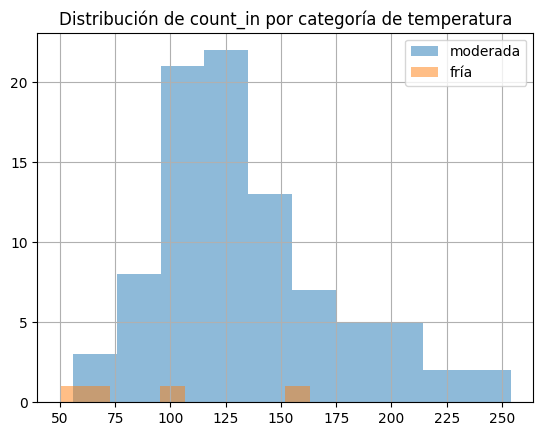

Shapiro-Wilk para moderada: p-valor = 0.0015272102318704128
Shapiro-Wilk para fría: p-valor = 0.4956572949886322
Test de Levene para varianzas iguales: p-valor = nan
Varianzas distintas, mejor usar Kruskal-Wallis.
Kruskal-Wallis: p-valor = nan


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
for categoria in df_dummy['categoria_temperatura'].unique():
    df_dummy[df_dummy['categoria_temperatura'] == categoria]['count_in'].hist(alpha=0.5, label=categoria)
    
plt.legend()
plt.title('Distribución de count_in por categoría de temperatura')
plt.show()

for categoria in df_dummy['categoria_temperatura'].unique():
    stat, p = shapiro(df_dummy[df_dummy['categoria_temperatura'] == categoria]['count_in'])
    print(f"Shapiro-Wilk para {categoria}: p-valor = {p}")

moderada = df_dummy[df_dummy['categoria_temperatura'] == 'moderada']['count_in']
baja = df_dummy[df_dummy['categoria_temperatura'] == 'fría']['count_in']
alta = df_dummy[df_dummy['categoria_temperatura'] == 'alta']['count_in']

stat_levene, p_levene = levene(moderada, baja, alta)
print("Test de Levene para varianzas iguales: p-valor =", p_levene)

if all(p > 0.05 for categoria in df_dummy['categoria_temperatura'].unique()):
    if p_levene > 0.05:
        stat_anova, p_anova = f_oneway(moderada, baja, alta)
        print("ANOVA: p-valor =", p_anova)
    else:
        print("Varianzas distintas, mejor usar Kruskal-Wallis.")
        stat_kw, p_kw = kruskal(moderada, baja, alta)
        print("Kruskal-Wallis: p-valor =", p_kw)
else:
    stat_kw, p_kw = kruskal(moderada, baja, alta)
    print("Kruskal-Wallis: p-valor =", p_kw)


## Modelo de predicción

In [18]:
festivos_valencianos = [
    '2024-01-01',  # Año Nuevo
    '2024-01-06',  # Reyes
    '2024-03-19',  # San José
    '2024-04-18',  # Viernes Santo
    '2024-04-21',  # Lunes de Pascua
    '2024-05-01',  # Día del Trabajador
    '2024-08-15',  # Asunción
    '2024-10-09',  # Día de la Comunidad Valenciana
    '2024-10-12',  # Fiesta Nacional de España
    '2024-11-01',  # Todos los Santos
    '2024-12-06',  # Día de la Constitución
    '2024-12-08',  # Inmaculada Concepción
    '2024-12-25',  # Navidad
]

df_regression = df_dummy[['fecha', 'count_in', 'lluvia', 'fin_de_semana', 'categoria_temperatura']].copy() #incluimos lluvia yq ue pese a que no es significaqtiva en regresión puede serlo en predicción

festivos_valencianos = [datetime.strptime(fecha, '%Y-%m-%d').date() for fecha in festivos_valencianos]
df_regression['fecha'] = pd.to_datetime(df_regression['fecha'])
df_regression['dia_semana'] = df_regression['fecha'].dt.dayofweek
df_regression['mes'] = df_regression['fecha'].dt.month
df_regression['festivo'] = df_regression.apply(
    lambda row: 1 if (row['fecha'].date() in festivos_valencianos or row['dia_semana'] in [6, 7]) else 0,
    axis=1)
df_regression

,fecha,count_in,lluvia,fin_de_semana,categoria_temperatura,dia_semana,mes,festivo
0,2024-09-10,98.0,0,0,moderada,1,9,0
1,2024-09-11,114.0,0,0,moderada,2,9,0
2,2024-09-12,133.0,0,0,moderada,3,9,0
3,2024-09-13,167.0,0,0,moderada,4,9,0
4,2024-09-14,199.0,1,1,moderada,5,9,0
...,...,...,...,...,...,...,...,...
87,2024-12-06,151.0,0,0,moderada,4,12,1
88,2024-12-07,128.0,0,1,moderada,5,12,0
89,2024-12-08,163.0,0,1,fría,6,12,1
90,2024-12-09,50.0,0,0,fría,0,12,0


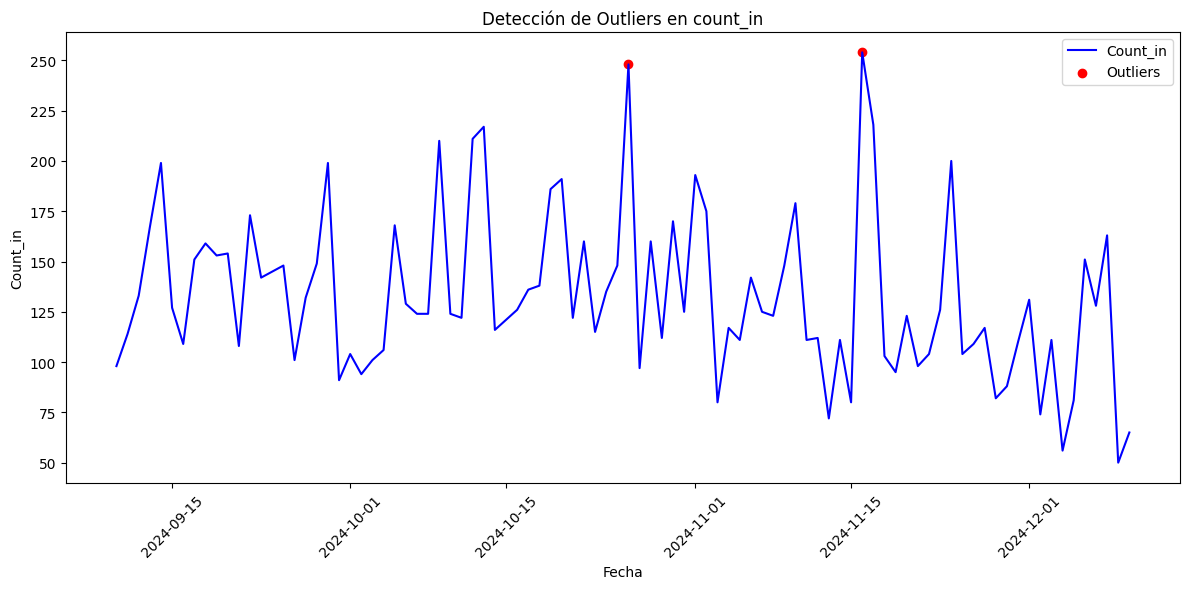

In [ ]:
Q1 = df_regression['count_in'].quantile(0.25)
Q3 = df_regression['count_in'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_regression['is_outlier'] = (df_regression['count_in'] < lower_bound) | (df_regression['count_in'] > upper_bound)

plt.figure(figsize=(12, 6))
plt.plot(df_regression['fecha'], df_regression['count_in'], label='Count_in', color='blue')
plt.scatter(df_regression[df_regression['is_outlier']]['fecha'],
            df_regression[df_regression['is_outlier']]['count_in'],
            color='red', label='Outliers')
plt.xlabel('Fecha')
plt.ylabel('Count_in')
plt.title('Detección de Outliers en count_in')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_regression = df_regression[~df_regression['is_outlier']]
df_regression = df_regression.drop(columns='is_outlier')

### Random forest

In [31]:
df = df_regression.copy()
X = df.drop(columns=['count_in', 'fecha'])
y = df['count_in']

preprocesador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['categoria_temperatura'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('prepro', preprocesador),
    ('modelo', RandomForestRegressor(random_state=42)) 
])

param_dist = {
    'modelo__n_estimators': [50, 100, 200, 300],
    'modelo__max_depth': [10, 20, 30, None],
    'modelo__min_samples_split': [2, 5, 10, 15, 20],
    'modelo__min_samples_leaf': [1, 2, 4, 6]
}

search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                            n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)
search.fit(X, y)

print("Mejor combinación de hiperparámetros:", search.best_params_)

best_pipeline = search.best_estimator_
scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE promedio (CV 5):", -scores.mean())

y_pred_cv = cross_val_predict(best_pipeline, X, y, cv=5)

rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
print("RMSE (CV 5):", rmse)

r2 = r2_score(y, y_pred_cv)
print("R² (CV 5):", r2)

mape = mean_absolute_percentage_error(y, y_pred_cv)
print("MAPE (CV 5):", mape)

medae = median_absolute_error(y, y_pred_cv)
print("Mediana del Error Absoluto (MedAE) (CV 5):", medae)

max_err = max_error(y, y_pred_cv)
print("Error Máximo (CV 5):", max_err)

evs = explained_variance_score(y, y_pred_cv)
print("Explained Variance Score (CV 5):", evs)

best_pipeline.fit(X, y)

nueva_fecha = pd.DataFrame({
    'lluvia': [1],
    'fin_de_semana': [0],
    'categoria_temperatura': ['moderada'],
    'dia_semana': [1],
    'mes': [9],
    'festivo': [0]
})
prediccion = best_pipeline.predict(nueva_fecha)
print("Predicción de visitantes:", prediccion[0])
prediccion


Mejor combinación de hiperparámetros: {'modelo__n_estimators': 200, 'modelo__min_samples_split': 5, 'modelo__min_samples_leaf': 2, 'modelo__max_depth': 30}
MAE promedio (CV 5): 25.900335175164333
RMSE (CV 5): 32.26951396835305
R² (CV 5): 0.24150387964306397
MAPE (CV 5): 0.2252885022007376
Mediana del Error Absoluto (MedAE) (CV 5): 24.17998088023087
Error Máximo (CV 5): 102.29850793650795
Explained Variance Score (CV 5): 0.24207728031097542


ValueError: columns are missing: {'is_outlier'}

### Prophet + LightGBM

- Quitamos datos anómalos ( count in > 225)
- Usamos Prophet con lluvia, fin de semana y festivo como regresores
- Predecimos a partir de los residuos usando LightGBM

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\hugol\AppData\Local\Temp\tmph_l4n3q3\m_l8byat.json
DEBUG:cmdstanpy:input tempfile: C:\Users\hugol\AppData\Local\Temp\tmph_l4n3q3\bo4wm1tm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\hugol\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=59070', 'data', 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor combinación de hiperparámetros: {'modelo__num_leaves': 20, 'modelo__n_estimators': 400, 'modelo__min_child_samples': 30, 'modelo__max_depth': 10, 'modelo__learning_rate': 0.03}

Métricas del modelo híbrido Prophet + LightGBM:
RMSE: 26.30
R²: 0.500
MAPE: 17.50%
MedAE: 13.23
Max Error: 75.19
Explained Variance: 0.500
🔮 Predicción final (nueva muestra): 84.73


C:\Users\hugol\AppData\Local\Temp\ipykernel_33324\2269046174.py:102: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


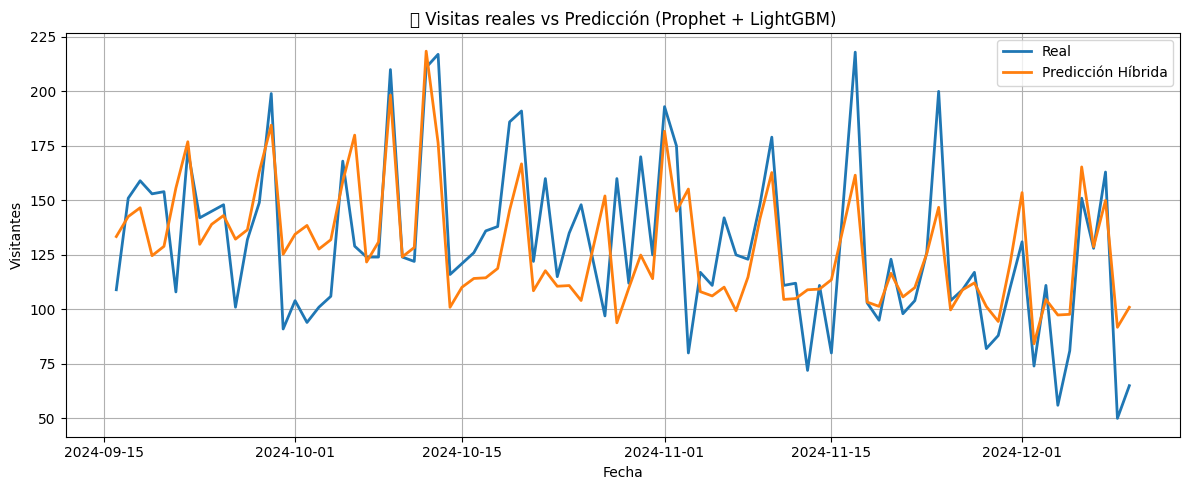

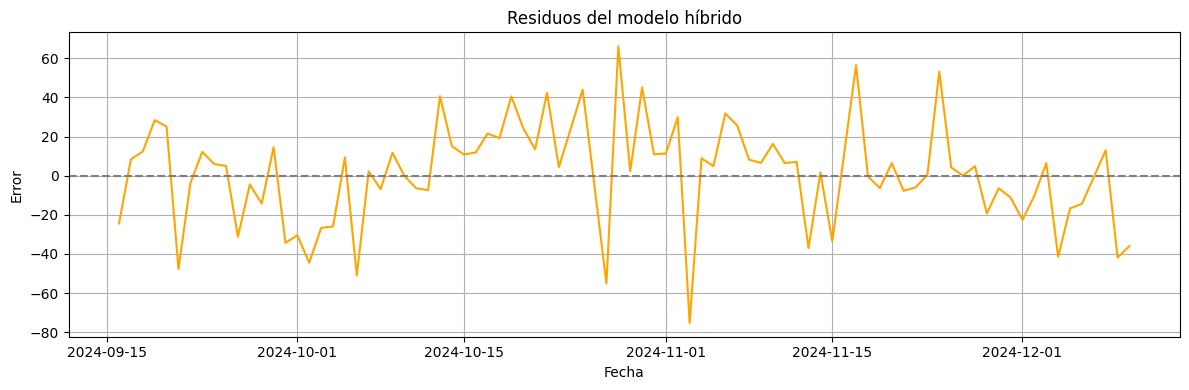

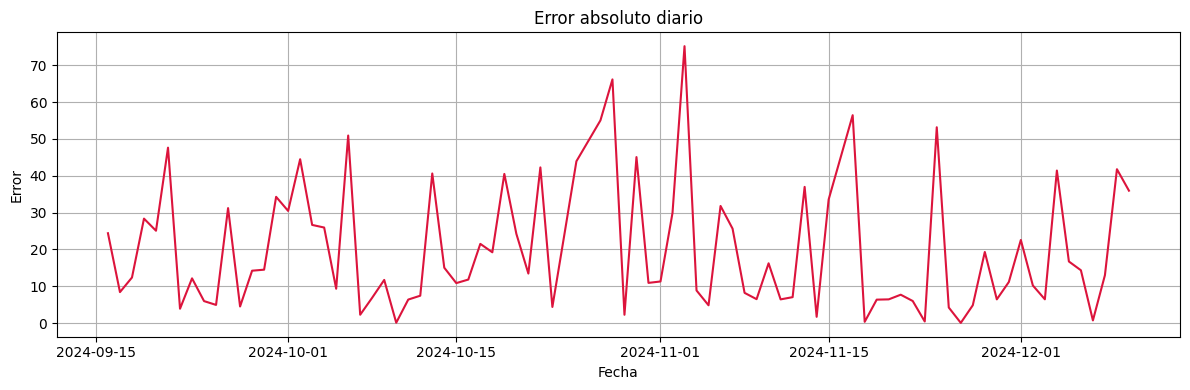

In [20]:
# --- Preparación de datos ---
df = df_regression[['fecha', 'count_in', 'lluvia', 'fin_de_semana', 'festivo']].copy()
df['fecha'] = pd.to_datetime(df['fecha'])
df = df[df['count_in'] <= 225].copy()
df = df.sort_values('fecha')
df['tendencia_movil'] = df['count_in'].rolling(7).mean()

df.dropna(inplace=True)

df_prophet = df.rename(columns={'fecha': 'ds', 'count_in': 'y'})
modelo_prophet = Prophet()
for reg in ['lluvia', 'fin_de_semana', 'festivo']:
    modelo_prophet.add_regressor(reg)
modelo_prophet.fit(df_prophet[['ds', 'y', 'lluvia', 'fin_de_semana', 'festivo']])

forecast = modelo_prophet.predict(df_prophet[['ds', 'lluvia', 'fin_de_semana', 'festivo']])
df['yhat_prophet'] = forecast['yhat'].values
df['residuo'] = df['count_in'] - df['yhat_prophet']

X = df.drop(columns=['count_in', 'fecha', 'yhat_prophet', 'residuo'])
y = df['residuo']


pipeline = Pipeline(steps=[
    ('modelo', LGBMRegressor(random_state=42, verbose=-1))
])

param_dist = {
    'modelo__n_estimators': [300, 400, 500, 600],
    'modelo__max_depth': [6, 8, 10, 12],
    'modelo__learning_rate': [0.01, 0.03, 0.05, 0.07],
    'modelo__num_leaves': [20, 31, 40, 50],
    'modelo__min_child_samples': [10, 20, 30]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search.fit(X, y)
print("Mejor combinación de hiperparámetros:", search.best_params_)
best_pipeline = search.best_estimator_

tscv = TimeSeriesSplit(n_splits=5)
y_pred_resid = np.zeros(len(y))

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    best_pipeline.fit(X_train, y_train)
    y_pred_resid[test_idx] = best_pipeline.predict(X_test)

y_pred_final = df['yhat_prophet'].values + y_pred_resid

print("\nMétricas del modelo híbrido Prophet + LightGBM:")
print(f"RMSE: {np.sqrt(mean_squared_error(df['count_in'], y_pred_final)):.2f}")
print(f"R²: {r2_score(df['count_in'], y_pred_final):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(df['count_in'], y_pred_final):.2%}")
print(f"MedAE: {median_absolute_error(df['count_in'], y_pred_final):.2f}")
print(f"Max Error: {max_error(df['count_in'], y_pred_final):.2f}")
print(f"Explained Variance: {explained_variance_score(df['count_in'], y_pred_final):.3f}")

best_pipeline.fit(X, y)

último = df.iloc[-1]
nueva_muestra = {
    'lluvia': [1],
    'fin_de_semana': [0],
    'festivo': [0],
    'tendencia_movil': [df['count_in'].rolling(7).mean().iloc[-1]]
}
nueva_fecha = pd.DataFrame(nueva_muestra)

proxima_fecha = pd.to_datetime(último['fecha']) + pd.Timedelta(days=1)
future_df = pd.DataFrame({
    'ds': [proxima_fecha],
    'lluvia': [1],
    'fin_de_semana': [0],
    'festivo': [0]
})
pred_prophet = modelo_prophet.predict(future_df)['yhat'].values[0]
pred_resid = best_pipeline.predict(nueva_fecha)[0]
pred_final = pred_prophet + pred_resid
print(f"🔮 Predicción final (nueva muestra): {pred_final:.2f}")


plt.figure(figsize=(12, 5))
plt.plot(df['fecha'], df['count_in'], label='Real', linewidth=2)
plt.plot(df['fecha'], y_pred_final, label='Predicción Híbrida', linewidth=2)
plt.title('📈 Visitas reales vs Predicción (Prophet + LightGBM)')
plt.xlabel('Fecha')
plt.ylabel('Visitantes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
residuos_hibrido = df['count_in'] - y_pred_final
plt.plot(df['fecha'], residuos_hibrido, label='Residuos', color='orange')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuos del modelo híbrido')
plt.xlabel('Fecha')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
error_abs = np.abs(df['count_in'] - y_pred_final)
plt.plot(df['fecha'], error_abs, label='Error Absoluto', color='crimson')
plt.title('Error absoluto diario')
plt.xlabel('Fecha')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Visualización y comparación de resultados

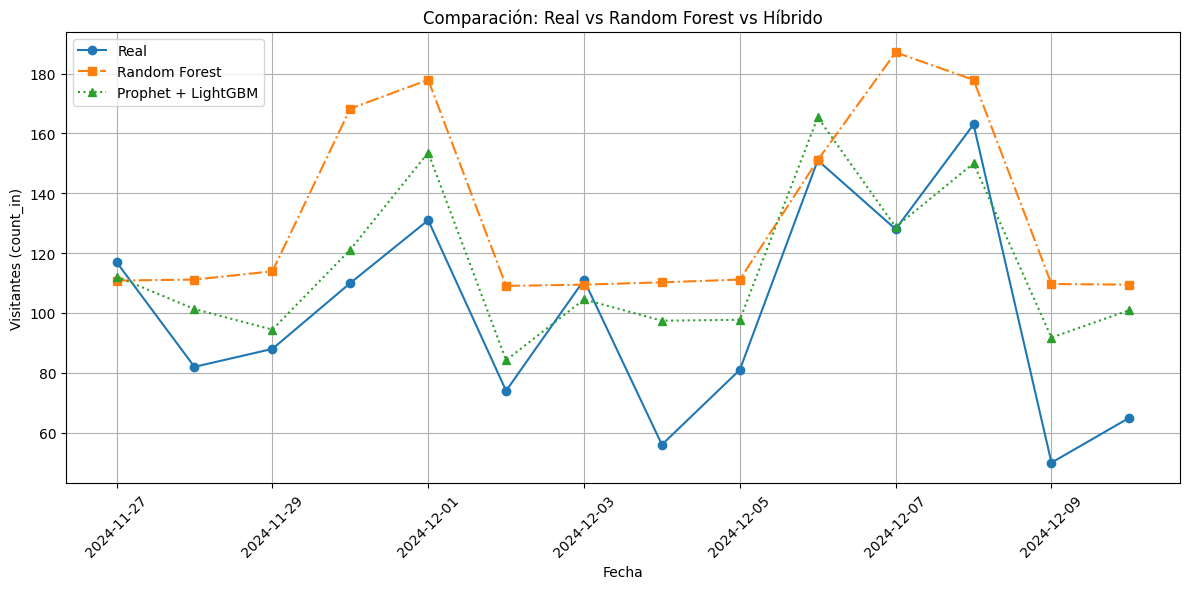

In [22]:
df_comparacion = pd.DataFrame({
    'Fecha': df['fecha'].values[-14:],
    'Real': df['count_in'].values[-14:],
    # 'TimeGPT': forecast['TimeGPT'].values[-14:],
    'RandomForest': y_pred_cv[-14:],
    'Hibrido': y_pred_final[-14:]
})

# df_comparacion['Error_TimeGPT'] = abs(df_comparacion['Real'] - df_comparacion['TimeGPT'])
df_comparacion['Error_RF'] = abs(df_comparacion['Real'] - df_comparacion['RandomForest'])
df_comparacion['Error_Hibrido'] = abs(df_comparacion['Real'] - df_comparacion['Hibrido'])

df_comparacion.set_index('Fecha', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_comparacion.index, df_comparacion['Real'], label='Real', marker='o')
# plt.plot(df_comparacion.index, df_comparacion['TimeGPT'], label='TimeGPT', linestyle='--', marker='x')
plt.plot(df_comparacion.index, df_comparacion['RandomForest'], label='Random Forest', linestyle='-.', marker='s')
plt.plot(df_comparacion.index, df_comparacion['Hibrido'], label='Prophet + LightGBM', linestyle=':', marker='^')

plt.title('Comparación: Real vs Random Forest vs Híbrido')
plt.xlabel('Fecha')
plt.ylabel('Visitantes (count_in)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


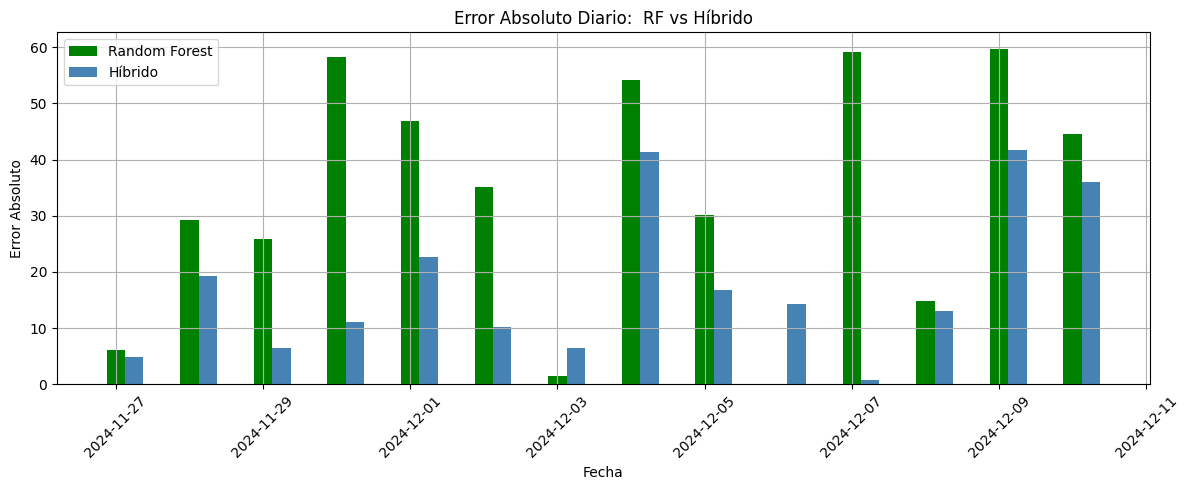

In [23]:
plt.figure(figsize=(12, 5))
offset = pd.Timedelta(days=0.25)

# plt.bar(df_comparacion.index - offset, df_comparacion['Error_TimeGPT'], width=0.25, label='TimeGPT', color='orange')
plt.bar(df_comparacion.index, df_comparacion['Error_RF'], width=0.25, label='Random Forest', color='green')
plt.bar(df_comparacion.index + offset, df_comparacion['Error_Hibrido'], width=0.25, label='Híbrido', color='steelblue')

plt.title('Error Absoluto Diario:  RF vs Híbrido')
plt.ylabel('Error Absoluto')
plt.xlabel('Fecha')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


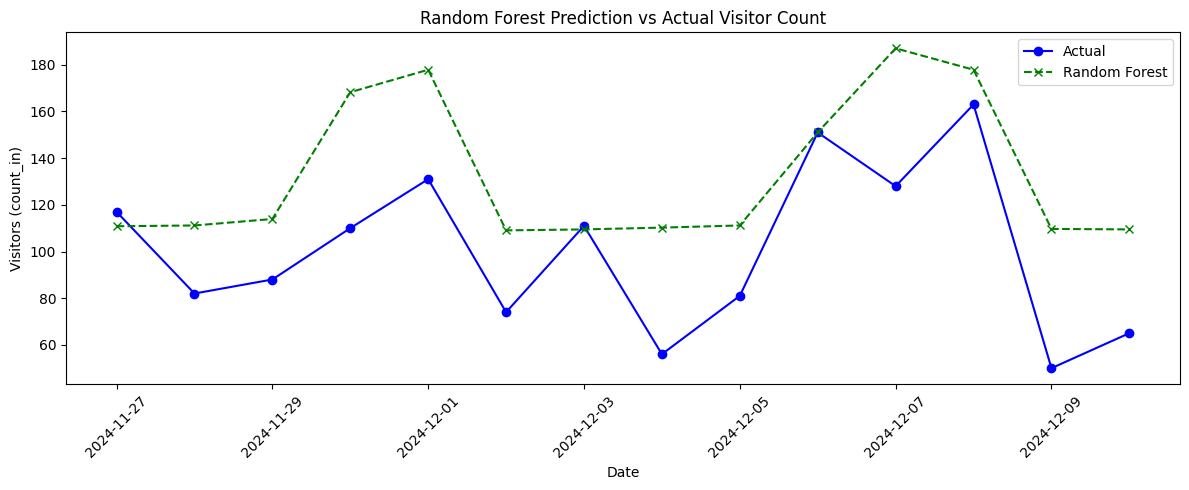

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(df_comparacion.index, df_comparacion['Real'], label='Actual', color='blue', marker='o')
plt.plot(df_comparacion.index, df_comparacion['RandomForest'], label='Random Forest', color='green', linestyle='--', marker='x')
plt.title('Random Forest Prediction vs Actual Visitor Count')
plt.xlabel('Date')
plt.ylabel('Visitors (count_in)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
df = df_regression.copy()
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')

umbral_pico = 200
df['pico'] = (df['count_in'] > umbral_pico).astype(int)

fechas_pico = df[df['pico'] == 1][['fecha', 'count_in']]
print(f"🔍 Se encontraron {len(fechas_pico)} días con picos (count_in > 225)")
print(fechas_pico)


🔍 Se encontraron 6 días con picos (count_in > 225)
        fecha  count_in
29 2024-10-09     210.0
32 2024-10-12     211.0
33 2024-10-13     217.0
46 2024-10-26     248.0
67 2024-11-16     254.0
68 2024-11-17     218.0
